In [1]:
import numpy as np
import pandas as pd
from scipy.io import mmread
import os
import glob
import anndata
import tqdm
import zarr
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

from dredFISH.Utils import basicu
from dredFISH.Utils import powerplots

- merge marker genes (types ABC)
- feed into NN design

In [2]:
pth = '/bigstore/GeneralStorage/fangming/projects/visctx/data_dump/counts/scRNAseq_Cheng2022_Cell_v1ctx/P38_nr_1_a/filtered_feature_bc_matrix'
f = os.path.join(pth, 'counts.h5ad')
adata = anndata.read(f)
adata.obs.index = np.char.add(adata.obs.index.values.astype(str), "-P38_1a-P38")
adata

AnnData object with n_obs × n_vars = 10357 × 53801
    var: 'id', 'name'

In [3]:
cov = np.asarray(adata.X.sum(axis=1)).reshape(-1,)
medcov = np.median(cov)

adata.obs['cov'] = cov
adata.obs['covfactor'] = cov/medcov

In [4]:
data_dir = '/bigstore/GeneralStorage/fangming/projects/visctx/data_dump/'

In [5]:
f = '../data_dump/candidate_genes_vincent_0503_v2.csv'
df0 = pd.read_csv(f)
df0 = df0.sort_values(['Subclass', 'Type/Gradient'])
df0 = df0[df0['Gene']!='Neurod1']
df0 = df0.set_index('Gene')
df0

,Subclass,Type/Gradient,Function,Priority,Allen marker
Gene,,,,,
Baz1a,L2/3,A<B>C,TF,***,NaN
Bdnf,L2/3,A<B>C,CAM,***,NaN
Cdh4,L2/3,A<B>C,CAM,***,NaN
Epha3,L2/3,A<B>C,CAM,***,NaN
Grm8,L2/3,A<B>C,IC,NaN,NaN
...,...,...,...,...,...
Rrad,L2/3,NaN,other,NaN,x
S100a6,L2/3,NaN,other,NaN,x
Chrm2,"L2/3, L4",C>B=A,IC,***,NaN


In [6]:
df0['Type/Gradient'].unique(), df0['Subclass'].unique()

(array(['A<B>C', 'A>B=C', 'A>B>C', 'A>C>B', 'C>A>B', 'C>B=A', 'C>B>A',
        'all', nan], dtype=object),
 array(['L2/3', 'L2/3, L4', 'L4'], dtype=object))

In [7]:
genes = df0.index.values
allen_genes = df0[~df0['Allen marker'].isnull()].index.values
allen_genes.shape

(14,)

In [8]:
f = os.path.join(data_dir, 'genes_lasso_all83_May13.csv')
g1 = pd.read_csv(f, index_col=0)
print(g1.shape)

f = os.path.join(data_dir, 'genes_lasso_nonallen_May13.csv')
g2 = pd.read_csv(f, index_col=0)
print(g2.shape)

(16, 10)
(17, 10)


In [9]:
%%time
adatasub = anndata.read('../data_dump/P38_glut_genes_v3.h5ad')
adatasub

CPU times: user 234 ms, sys: 1.22 s, total: 1.45 s
Wall time: 3.66 s


AnnData object with n_obs × n_vars = 5837 × 83
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'layer', 'Type', 'Subclass'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Type_colors', 'cluster_colors', "dendrogram_['leiden']", 'hvg', 'layer_colors', 'leiden', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [10]:
adatasub.obs['sample'].unique()

['P38_1a', 'P38_2a', 'P38_2b']
Categories (3, object): ['P38_1a', 'P38_2a', 'P38_2b']

In [11]:
tmp = adata[adatasub[adatasub.obs['sample']=='P38_1a'].obs.index].copy()
unq, inv, cnt = np.unique(tmp.var['name'].values, return_counts=True, return_inverse=True)
tmp = tmp[:, cnt[inv] == 1]
genes_idx = basicu.get_index_from_array(tmp.var['name'].values.astype(str), df0.index.values.astype(str))
tmp = tmp[:, genes_idx]
tmp.var = tmp.var.set_index('name')
tmp

/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/anndata/_core/anndata.py:801: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['Baz1a', 'Bdnf', 'Cdh4', 'Epha3', 'Grm8']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


AnnData object with n_obs × n_vars = 1549 × 83
    obs: 'cov', 'covfactor'
    var: 'id'

In [12]:
mat = np.asarray(tmp.X.todense())
matnorm = mat/tmp.obs['covfactor'].values.reshape(-1,1)
mat.shape, matnorm.shape

((1549, 83), (1549, 83))

In [13]:
tmp.layers['normed'] = matnorm

In [14]:
pca = PCA(n_components=10)
pcs = pca.fit_transform(matnorm)
pca.explained_variance_ratio_

array([0.2941775 , 0.17962593, 0.1469529 , 0.07723071, 0.05958724,
       0.02850164, 0.02409803, 0.02143888, 0.02083515, 0.01819515],
      dtype=float32)

In [15]:
meta = adatasub.obs.loc[tmp.obs.index]
df = meta.join(pd.DataFrame(matnorm, index=meta.index, columns=tmp.var.index.values))
for i in range(pcs.shape[1]):
    df[f'PC{i+1}'] = pcs[:,i]
df

,batch,n_genes,percent_mito,n_counts,leiden,Doublet,Doublet Score,cluster,Class_broad,sample,...,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
AAACCCAAGTGACACG-1-P38_1a-P38,P38,2931,0.001048,8590.0,0,False,0.010833,L2/3_B,Excitatory,P38_1a,...,-1.991424,-15.338961,4.223588,16.785809,0.602549,0.766794,7.695529,-0.481854,-2.491899,6.888783
AAACGCTAGTACAGAT-1-P38_1a-P38,P38,4451,0.000952,13659.0,6,False,0.061252,L4_A,Excitatory,P38_1a,...,21.749052,-0.457189,-2.488413,19.285397,-4.528033,1.599425,-3.190095,3.703699,-1.686687,0.783547
AAACGCTAGTGAGGCT-1-P38_1a-P38,P38,4543,0.001475,16269.0,6,False,0.048147,L4_A,Excitatory,P38_1a,...,18.360855,-5.970790,-1.450687,21.306067,-6.221281,3.096870,-6.048932,5.312241,0.695090,3.351557
AAACGCTGTATGGAAT-1-P38_1a-P38,P38,2678,0.001813,6618.0,3,False,0.013447,L4_B,Excitatory,P38_1a,...,18.817369,1.378084,1.677459,-4.218071,-1.469402,-0.110043,3.447150,-0.739822,0.079123,-2.620019
AAAGAACAGTAGTCCT-1-P38_1a-P38,P38,3781,0.000159,12607.0,6,False,0.029642,L4_A,Excitatory,P38_1a,...,18.335222,-1.289011,-1.533683,12.147407,-0.562413,1.449506,2.517613,-1.067922,0.780233,-1.167724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGAGCAGATGCGA-1-P38_1a-P38,P38,2276,0.000511,5868.0,3,False,0.017461,L4_B,Excitatory,P38_1a,...,63.892124,9.463084,25.407648,-17.390562,19.605740,2.153161,1.175936,-5.076883,-3.768460,-1.743123
TTTGGTTAGGACACTG-1-P38_1a-P38,P38,4953,0.000338,17775.0,6,False,0.035124,L4_A,Excitatory,P38_1a,...,5.704209,-3.836637,-2.291459,3.308603,1.629466,-3.229111,-3.666499,3.308808,1.895673,-1.419888
TTTGGTTCACTTTATC-1-P38_1a-P38,P38,4399,0.000127,15758.0,0,False,0.061252,L2/3_B,Excitatory,P38_1a,...,-7.491241,-1.135511,5.861871,-4.080625,-4.174359,-0.808818,-2.324999,2.411196,1.779586,-1.889417
TTTGTTGCAGGTGAGT-1-P38_1a-P38,P38,2655,0.000753,6636.0,1,False,0.034145,L4_C,Excitatory,P38_1a,...,10.227140,14.306825,5.822817,-1.888519,0.058327,3.781137,0.676588,-3.249353,4.091763,-0.114125


In [16]:
# gene vs gene
genes_sub = [
    'Adamts2', 'Cdh13', 'Cntn5', 'Sorcs3', 
     'Kcnq5', 'Chrm2', 'Rorb', 'Kcnip3',
     ]

In [17]:
clstdict = {
    'L2/3_A': 'L2/3_A',
    'L2/3_B': 'L2/3_B',
    'L2/3_C': 'L2/3_C',
    'L4_A':   'L4',
    'L4_B':   'L4',
    'L4_C':   'L4',
}
clstdict = pd.Series(clstdict)

df['clst'] = clstdict.loc[df['cluster'].astype(str)].values
clsts = np.sort(df['clst'].unique())
clsts

array(['L2/3_A', 'L2/3_B', 'L2/3_C', 'L4'], dtype=object)

In [18]:
clstnums, labels = pd.factorize(clstdict.loc[df['cluster'].astype(str)], sort=True)
clstnums

array([1, 3, 3, ..., 1, 3, 1])

# normed

/tmp/ipykernel_1453845/590119959.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(g)


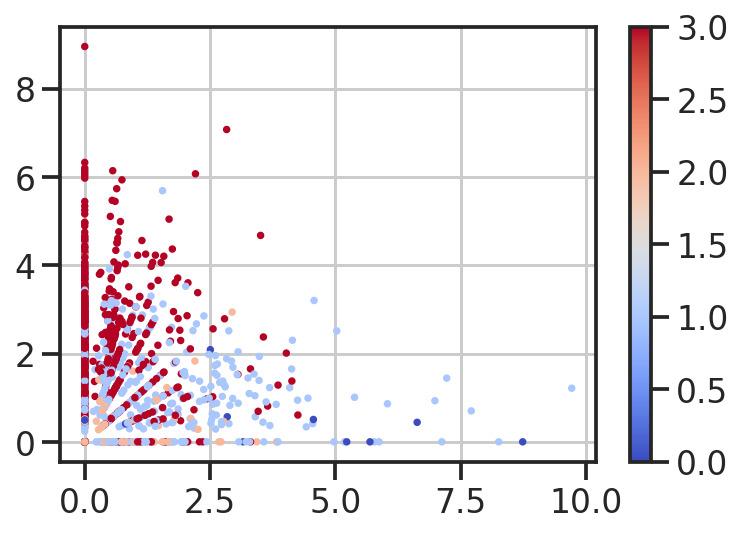

In [19]:
fig, ax = plt.subplots()
g = ax.scatter(matnorm[:,0]+matnorm[:,1], 
               matnorm[:,6], 
               c=clstnums,
               # c=[f'C{i}' for i in clstnums], 
               s=5, 
               cmap='coolwarm', 
               )
# ax.legend()
fig.colorbar(g)

/tmp/ipykernel_1453845/4049517300.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(g)


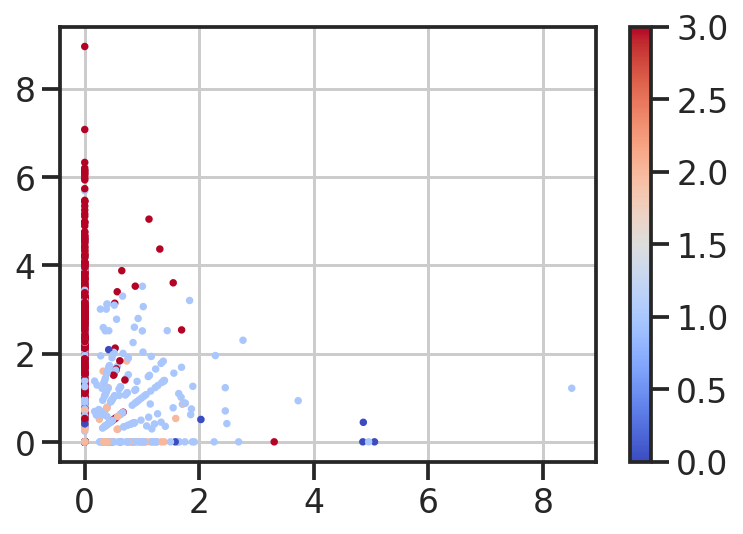

In [20]:
fig, ax = plt.subplots()
g = ax.scatter(matnorm[:,0], #+mat[:,1], 
               matnorm[:,6], 
               c=clstnums,
               s=5, 
               # c=[f'C{i}' for i in clstnums], 
               cmap='coolwarm', 
               )
# ax.legend()
fig.colorbar(g)

/tmp/ipykernel_1453845/786427532.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(g)


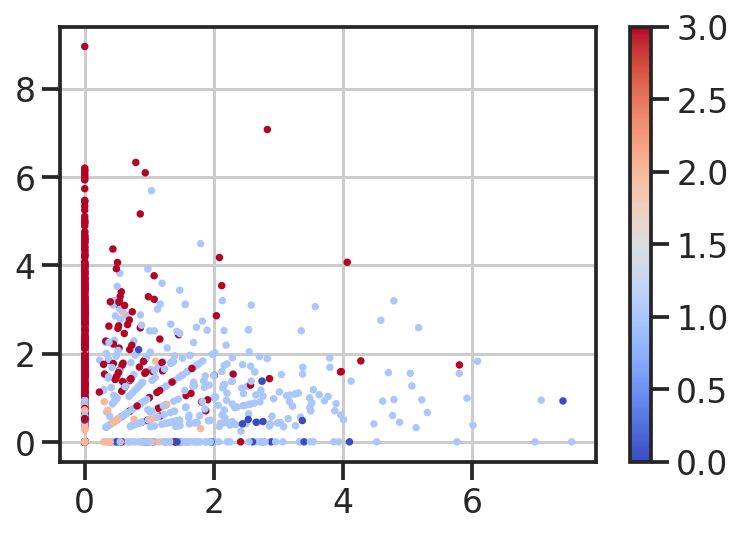

In [21]:
fig, ax = plt.subplots()
g = ax.scatter(matnorm[:,4], #+mat[:,1], 
               matnorm[:,6], 
               c=clstnums,
               s=5, 
               # c=[f'C{i}' for i in clstnums], 
               cmap='coolwarm', 
               )
# ax.legend()
fig.colorbar(g)

# groups

In [22]:
genes_a = [
    'Adamts2',
    'Cdh13',
    'Gabrg3',
    # 'Gria3',
]

genes_c = [
    'Kcnq5',
    'Cntnap2',
]

mat_a = tmp[:,genes_a].layers['normed']
mat_c = tmp[:,genes_c].layers['normed']
mat_a

ArrayView([[0.       , 0.       , 5.732247 ],
           [0.       , 1.0814848, 0.3604949],
           [0.       , 0.       , 3.0266151],
           ...,
           [0.       , 0.       , 2.812286 ],
           [0.       , 0.7420132, 0.7420132],
           [0.       , 0.       , 3.30322  ]], dtype=float32)

/tmp/ipykernel_1453845/4152482605.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(g)


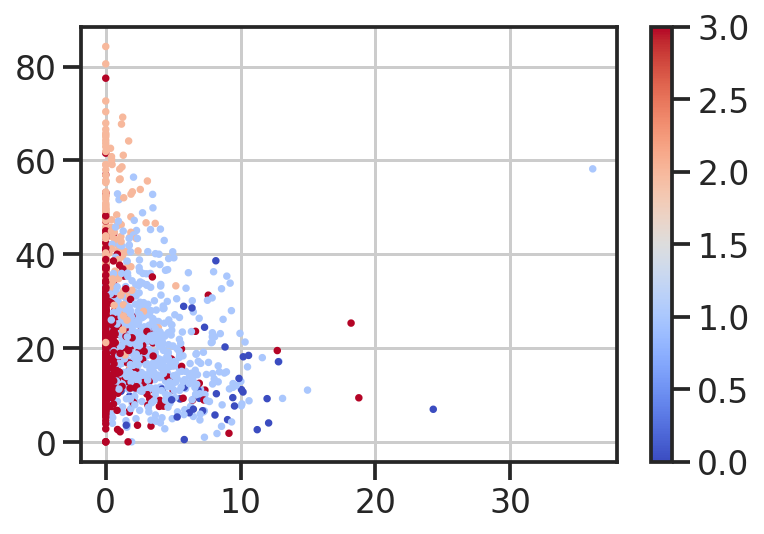

In [25]:
fig, ax = plt.subplots()
g = ax.scatter(mat_a.sum(axis=1), #+mat[:,1], 
               mat_c.sum(axis=1),
               c=clstnums,
               s=5, 
               # c=[f'C{i}' for i in clstnums], 
               cmap='coolwarm', 
               )
# ax.legend()
fig.colorbar(g)

/tmp/ipykernel_1453845/219845089.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(g)


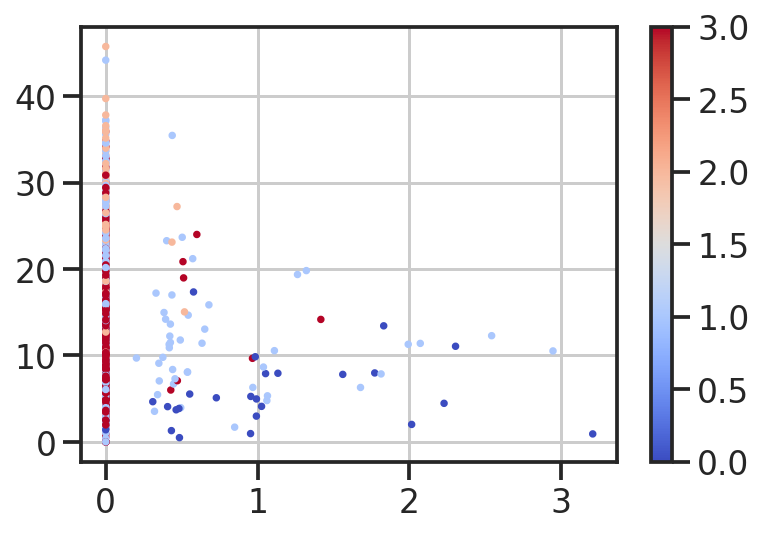

In [26]:
fig, ax = plt.subplots()
g = ax.scatter(mat_a[:,0], #+mat[:,1], 
               mat_c[:,0],
               c=clstnums,
               s=5, 
               # c=[f'C{i}' for i in clstnums], 
               cmap='coolwarm', 
               )
# ax.legend()
fig.colorbar(g)

<AxesSubplot:xlabel='clst', ylabel='Adamts2'>

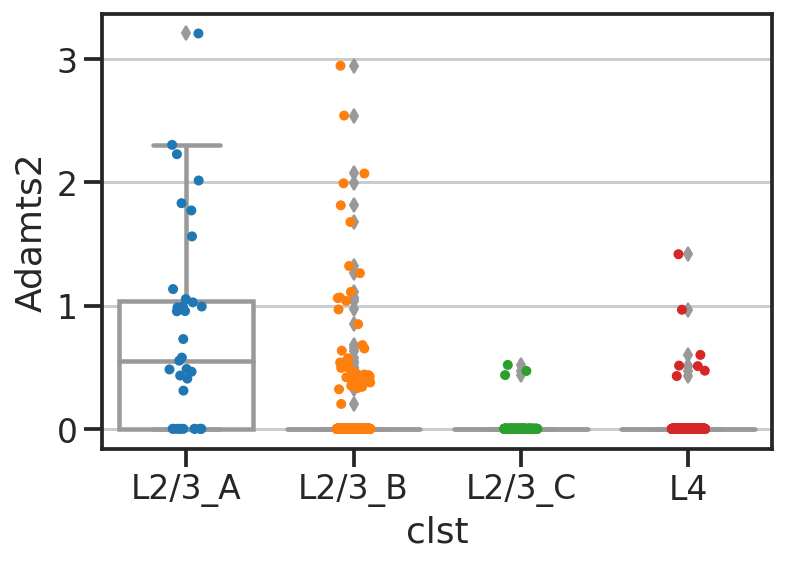

In [27]:
dfplot = df.copy()
sns.boxplot(data=dfplot, x='clst', y=genes_a[0], color='white', order=clsts)
sns.stripplot(data=dfplot, x='clst', y=genes_a[0], order=clsts)

<AxesSubplot:xlabel='clst', ylabel='sum'>

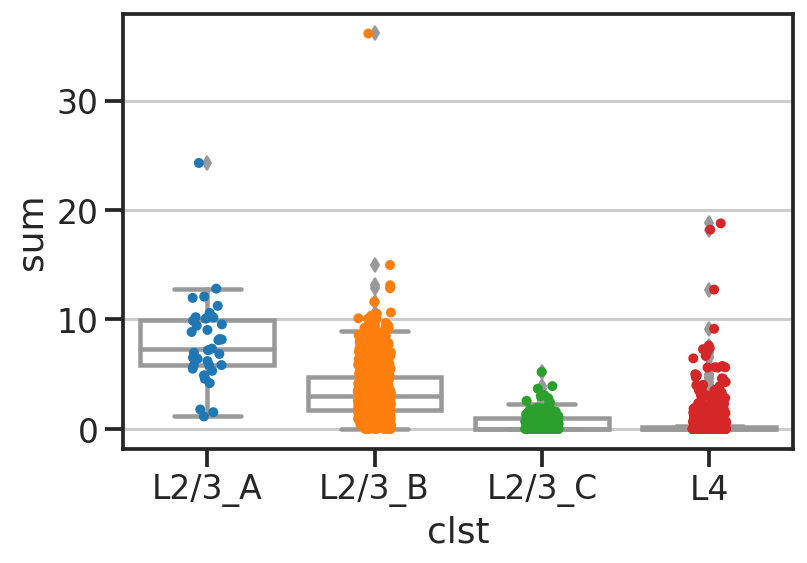

In [28]:
dfplot = df.copy()
dfplot['sum'] = dfplot[genes_a].sum(axis=1)
sns.boxplot(data=dfplot, x='clst', y='sum', color='white', order=clsts)
sns.stripplot(data=dfplot, x='clst', y='sum', order=clsts)

<AxesSubplot:xlabel='clst', ylabel='Kcnq5'>

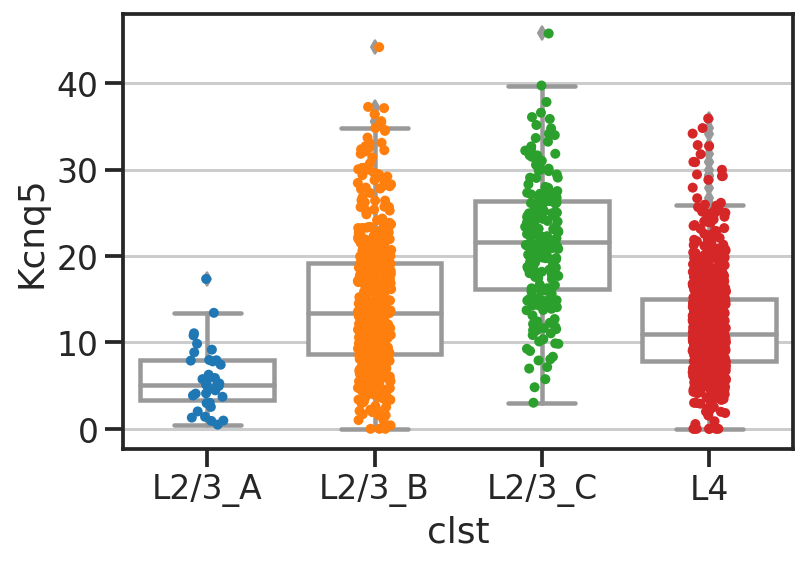

In [29]:
dfplot = df.copy()
sns.boxplot(data=dfplot, x='clst', y=genes_c[0], color='white', order=clsts)
sns.stripplot(data=dfplot, x='clst', y=genes_c[0], order=clsts)

<AxesSubplot:xlabel='clst', ylabel='sum'>

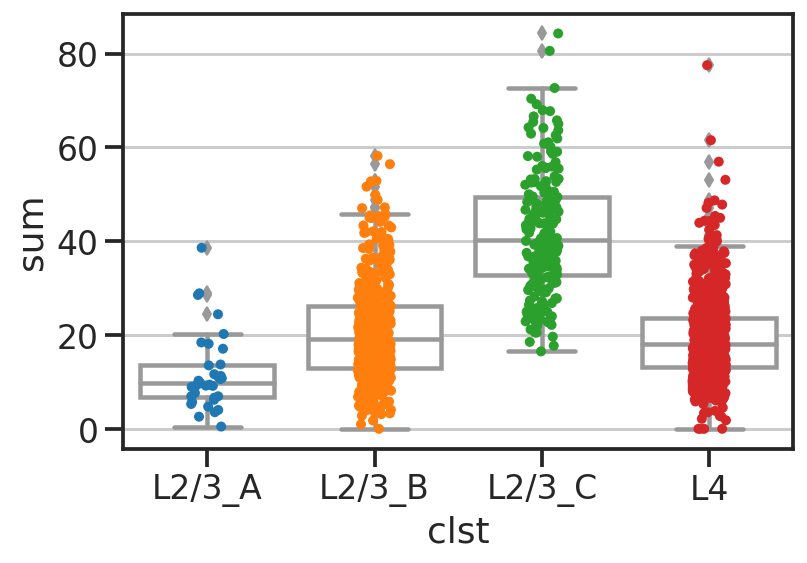

In [30]:
dfplot = df.copy()
dfplot['sum'] = dfplot[genes_c].sum(axis=1)
sns.boxplot(data=dfplot, x='clst', y='sum', color='white', order=clsts)
sns.stripplot(data=dfplot, x='clst', y='sum', order=clsts)

<AxesSubplot:xlabel='clst', ylabel='PC1'>

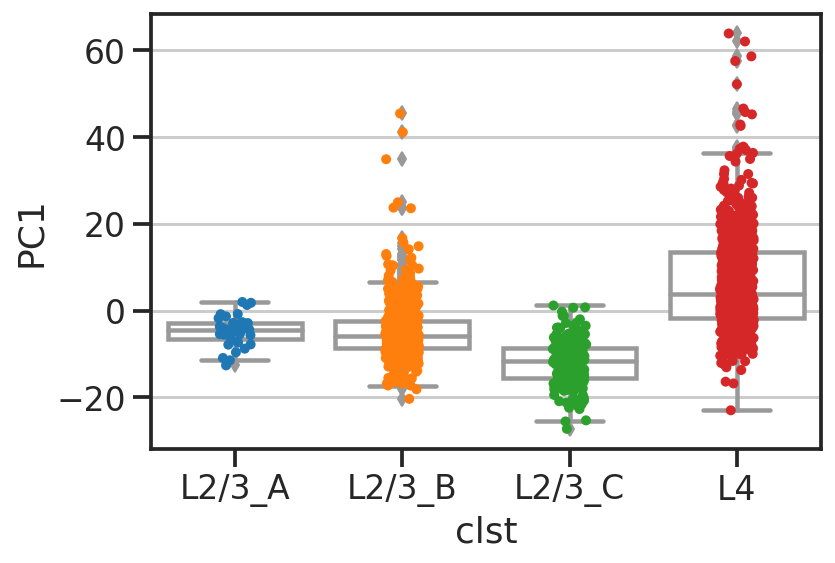

In [31]:
dfplot = df.copy()
sns.boxplot(data=dfplot, x='clst', y='PC1', color='white', order=clsts)
sns.stripplot(data=dfplot, x='clst', y='PC1', order=clsts)

<AxesSubplot:xlabel='clst', ylabel='PC2'>

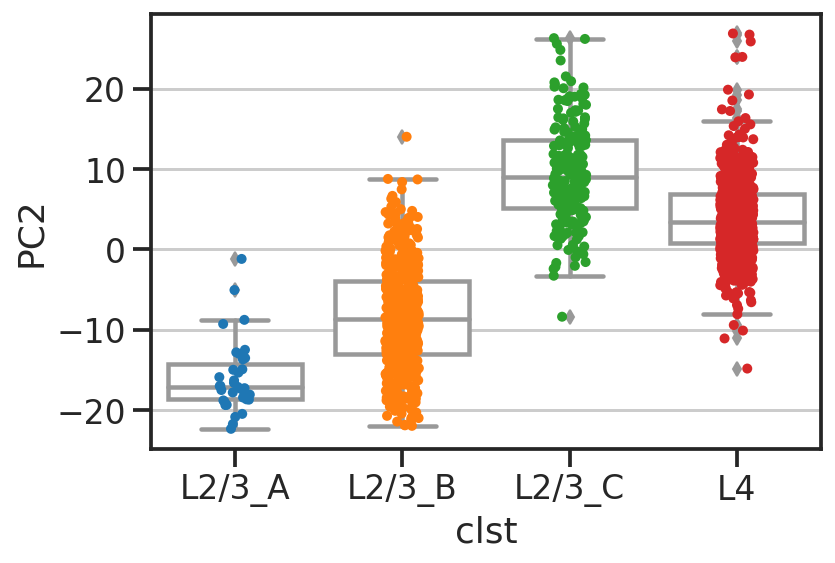

In [32]:
dfplot = df.copy()
sns.boxplot(data=dfplot, x='clst', y='PC2', color='white', order=clsts)
sns.stripplot(data=dfplot, x='clst', y='PC2', order=clsts)

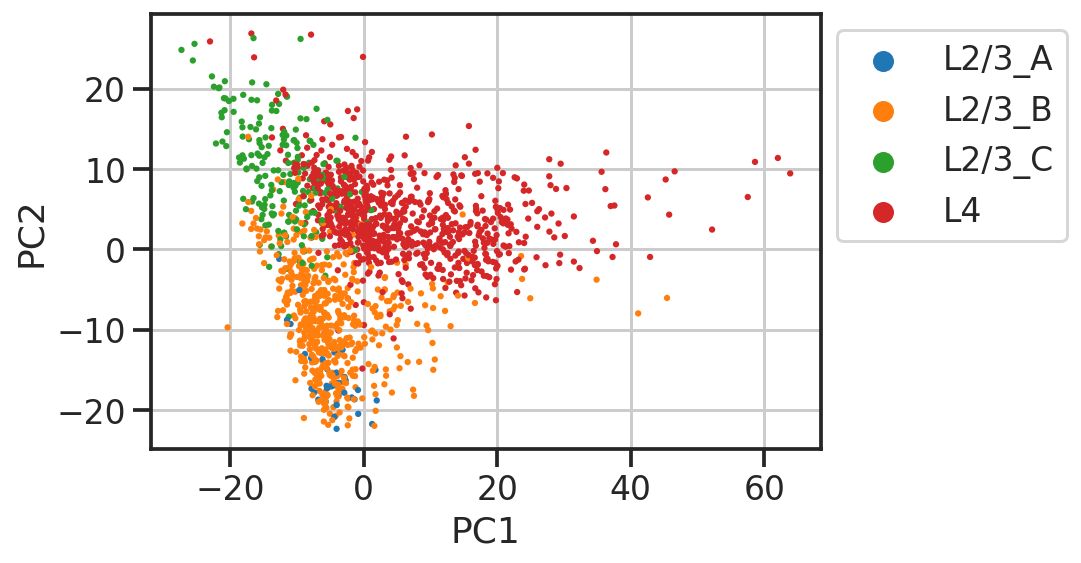

In [35]:
fig, ax = plt.subplots()
sns.scatterplot(data=df, x='PC1', y='PC2', hue='clst', edgecolor='none', s=10, hue_order=clsts, ax=ax)
ax.legend(bbox_to_anchor=(1,1))
plt.show()